In [56]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd
from skimage.feature import peak_local_max

import cv2
from skimage.io import imread

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({
    "pgf.texsystem": "xelatex",
    'font.family': 'serif',
    'text.usetex': False,
    'pgf.rcfonts': False,
    'figure.dpi': 300,
})

BASE_DIR = Path('F:\spatial_data_test\processed')
RUN_ID = '20221219_PRISM_E13.5_2_3_Three'
src_dir = BASE_DIR / f'{RUN_ID}_processed'
stc_dir = src_dir / 'stitched'
read_dir = src_dir / 'readout'
seg_dir = src_dir / 'segmented'
read_dir.mkdir(exist_ok=True)

## read spots

In [ ]:
TOPHAT_KERNEL_SIZE = 7
def tophat_spots(image):
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(TOPHAT_KERNEL_SIZE,TOPHAT_KERNEL_SIZE))
    return cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)

def extract_coordinates(image, snr=4, quantile=0.96):
    meta = {}
    coordinates = peak_local_max(image,min_distance=2,threshold_abs=snr*np.mean(image))
    meta['Coordinates brighter than given SNR'] = coordinates.shape[0]
    meta['Image mean intensity'] = float(np.mean(image))
    intensities = image[coordinates[:,0],coordinates[:,1]]
    meta[f'{quantile} quantile'] = float(np.quantile(intensities,quantile))
    threshold = np.quantile(intensities,quantile)
    coordinates = coordinates[image[coordinates[:,0],coordinates[:,1]]>threshold]
    meta['Final spots count'] = coordinates.shape[0]
    return coordinates

def find_signal(coordinates,im):
    Maxima = np.zeros(im.shape,dtype=np.uint16)
    Maxima[coordinates[:,0],coordinates[:,1]] = 255
    im[Maxima<=0] = 0 # Mask
    return im

In [ ]:
R_test = imread(stc_dir/'cyc_1_cy5.tif')
R_test.shape

In [4]:
QUANTILE = 0.1
kernel = np.ones((5,5), np.uint8)
R_test = imread(stc_dir/'cyc_1_cy5.tif')
#R_test = R_test[0:36000,0:56000]
R_test = tophat_spots(R_test)
R_test[R_test < 100] = 0
coordinates_R = extract_coordinates(R_test,8,quantile=QUANTILE)
R_test = find_signal(coordinates_R,R_test)
R_test = cv2.dilate(R_test,kernel,iterations=1)
#imsave(read_dir/'Dilate_R_whole.tif',R_test,check_contrast=False)

Ye_test = imread(stc_dir/'cyc_1_TxRed.tif')
#Ye_test = Ye_test[0:36000,0:56000]
Ye_test = tophat_spots(Ye_test)
Ye_test[Ye_test < 100] = 0
coordinates_Ye = extract_coordinates(Ye_test,8,quantile=QUANTILE)
Ye_test = find_signal(coordinates_Ye,Ye_test)
Ye_test = cv2.dilate(Ye_test,kernel,iterations=1)

G_test = imread(stc_dir/'cyc_1_cy3.tif')
#G_test = G_test[0:36000,0:56000]
G_test = tophat_spots(G_test)
G_test[G_test < 100] = 0
coordinates_G = extract_coordinates(G_test,8,quantile=QUANTILE)
G_test = find_signal(coordinates_G,G_test)
G_test = cv2.dilate(G_test,kernel,iterations=1)

B_test = imread(stc_dir/'cyc_1_FAM.tif')
#B_test = B_test[0:36000,0:56000]
B_test = tophat_spots(B_test)
B_test[B_test < 150] = 0 #100
coordinates_B = extract_coordinates(B_test,8,quantile=QUANTILE)
B_test = find_signal(coordinates_B,B_test)
B_test = cv2.dilate(B_test,kernel,iterations=1)
#imsave(read_dir/'Dilate_B_whole.tif',B_test,check_contrast=False)

In [5]:
print("R:", len(coordinates_R),"\nY:", len(coordinates_Ye),"\nG:", len(coordinates_G),"\nB:", len(coordinates_B))

R: 2702429 
Y: 1967965 
G: 1910031 
B: 3349728


In [7]:
intensity_R = pd.DataFrame({'Y':coordinates_R[:,0],'X':coordinates_R[:,1]})
intensity_R['R'] = R_test[coordinates_R[:,0],coordinates_R[:,1]]
intensity_R['Ye'] = Ye_test[coordinates_R[:,0],coordinates_R[:,1]]
intensity_R['G'] = G_test[coordinates_R[:,0],coordinates_R[:,1]]
intensity_R['B'] = B_test[coordinates_R[:,0],coordinates_R[:,1]]

intensity_Ye = pd.DataFrame({'Y':coordinates_Ye[:,0],'X':coordinates_Ye[:,1]})
intensity_Ye['R'] = R_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]
intensity_Ye['Ye'] = Ye_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]
intensity_Ye['G'] = G_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]
intensity_Ye['B'] = B_test[coordinates_Ye[:,0],coordinates_Ye[:,1]]

intensity_B = pd.DataFrame({'Y':coordinates_B[:,0],'X':coordinates_B[:,1]})
intensity_B['R'] = R_test[coordinates_B[:,0],coordinates_B[:,1]]
intensity_B['Ye'] = Ye_test[coordinates_B[:,0],coordinates_B[:,1]]
intensity_B['G'] = G_test[coordinates_B[:,0],coordinates_B[:,1]]
intensity_B['B'] = B_test[coordinates_B[:,0],coordinates_B[:,1]]

intensity_G = pd.DataFrame({'Y':coordinates_G[:,0],'X':coordinates_G[:,1]})
intensity_G['R'] = R_test[coordinates_G[:,0],coordinates_G[:,1]]
intensity_G['Ye'] = Ye_test[coordinates_G[:,0],coordinates_G[:,1]]
intensity_G['G'] = G_test[coordinates_G[:,0],coordinates_G[:,1]]
intensity_G['B'] = B_test[coordinates_G[:,0],coordinates_G[:,1]]


#merge three datasets
intensity_all = pd.concat([intensity_R,intensity_Ye,intensity_B,intensity_G])#,keys=['R','Ye','B','G'])

In [8]:
intensity_all.to_csv(read_dir/'intensity_all_5x5_not_cross_corrected.csv')

In [57]:
intensity_all = pd.read_csv(read_dir/'intensity_all_5x5_not_cross_corrected.csv').drop(columns='Unnamed: 0')
intensity_all

Y      X      R    Ye     G    B
0        37754  53541  24031     0     0    0
1         8637  59481  18804     0     0    0
2         8647  59471  17057     0     0    0
3        26032  68260  13793  5327  2025    0
4        13231  45794  12827   265  3558    0
...        ...    ...    ...   ...   ...  ...
8602147  38780   3364      0     0   106    0
8602148  18006  45487      0     0   106    0
8602149  20085  46892      0     0   106    0
8602150  21779   3764    147     0   106  326
8602151  37114   5540      0     0   106    0

[8602152 rows x 6 columns]

## correction of intensity

In [58]:
intensity_all = intensity_all.reset_index(drop=True)

#crosstalk elimination
intensity_all['B'] = intensity_all['B'] - intensity_all['G'] * 0.25 #0.35
intensity_all = np.maximum(intensity_all,0)

#Scale
intensity_all['Scaled_R'] = intensity_all['R']
intensity_all['Scaled_Ye'] = intensity_all['Ye']
intensity_all['Scaled_G'] = intensity_all['G'] * 2.5
intensity_all['Scaled_B'] = intensity_all['B'] #* 4/3
intensity_all['sum'] = intensity_all['Scaled_R'] + intensity_all['Scaled_Ye'] + intensity_all['Scaled_B']
intensity_all['sum_G'] = intensity_all['Scaled_R'] + intensity_all['Scaled_Ye'] + intensity_all['Scaled_B'] + intensity_all['Scaled_G']

#filter by sum value (QC)
intensity_all = intensity_all.drop(intensity_all[intensity_all['sum_G'] < 1000].index)
intensity_all = intensity_all.drop(intensity_all[intensity_all['sum'] > 20000].index)
intensity_all['R/A'] = intensity_all['Scaled_R'] / intensity_all['sum']
intensity_all['Ye/A'] = intensity_all['Scaled_Ye'] / intensity_all['sum']
intensity_all['B/A'] = intensity_all['Scaled_B'] / intensity_all['sum']
intensity_all['G/A'] = intensity_all['Scaled_G'] / intensity_all['sum']
intensity_all['X_coor'] = 2 * intensity_all['R/A'] - 1
intensity_all['Y_coor'] = intensity_all['B/A'] - intensity_all['Ye/A']

## visualization of spots

[  2  44  87 142]
[(-0.97, -0.98), (-0.55, -0.56), (-0.12, -0.13), (0.99, 1.0)]


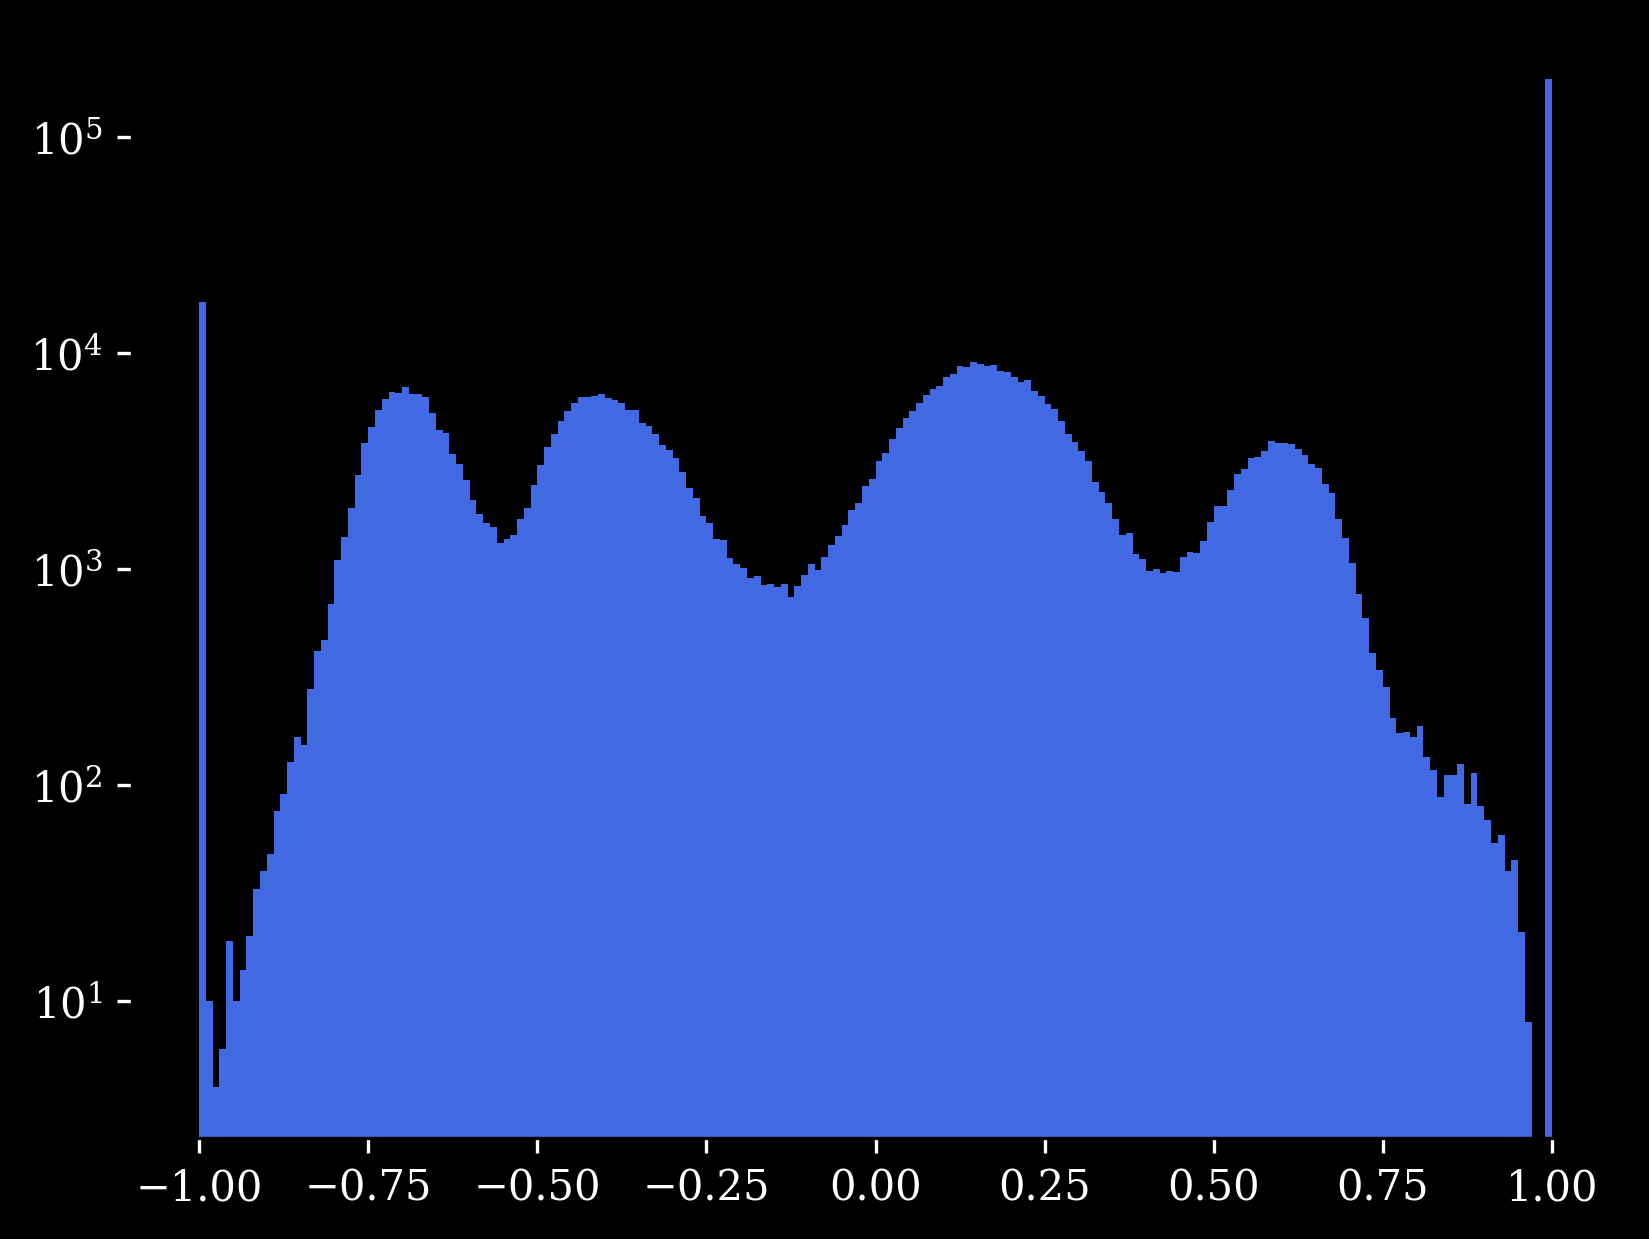

In [59]:
from scipy.signal import argrelextrema


RY = intensity_all[(intensity_all['R/A'] == 0)&(intensity_all['G/A'] >= 0.2)] 
order = 5
extension = 0

fig, ax = plt.subplots(facecolor='black')
hist = ax.hist(pd.DataFrame(RY['B/A'] - RY['Ye/A']), bins=200, 
               color='royalblue', log=True)
ax.set_facecolor('black')
ax.tick_params(colors='white')
ax.yaxis.label.set_color('white')
ax.xaxis.label.set_color('white')
ax.title.set_color('white')

freq, bins = hist[0], hist[1]
extrema_less = argrelextrema(freq, np.less, order=order)[0]
print(extrema_less)
bins_less = [(bins[extrema_less[i]+1] + extension, bins[extrema_less[i]] - extension) for i in range(len(extrema_less) - 1)]
bins_less.append((bins[-2], bins[-1]))
print(bins_less)

plt.savefig('BY_HH_PRISM.jpg')

plt.show()

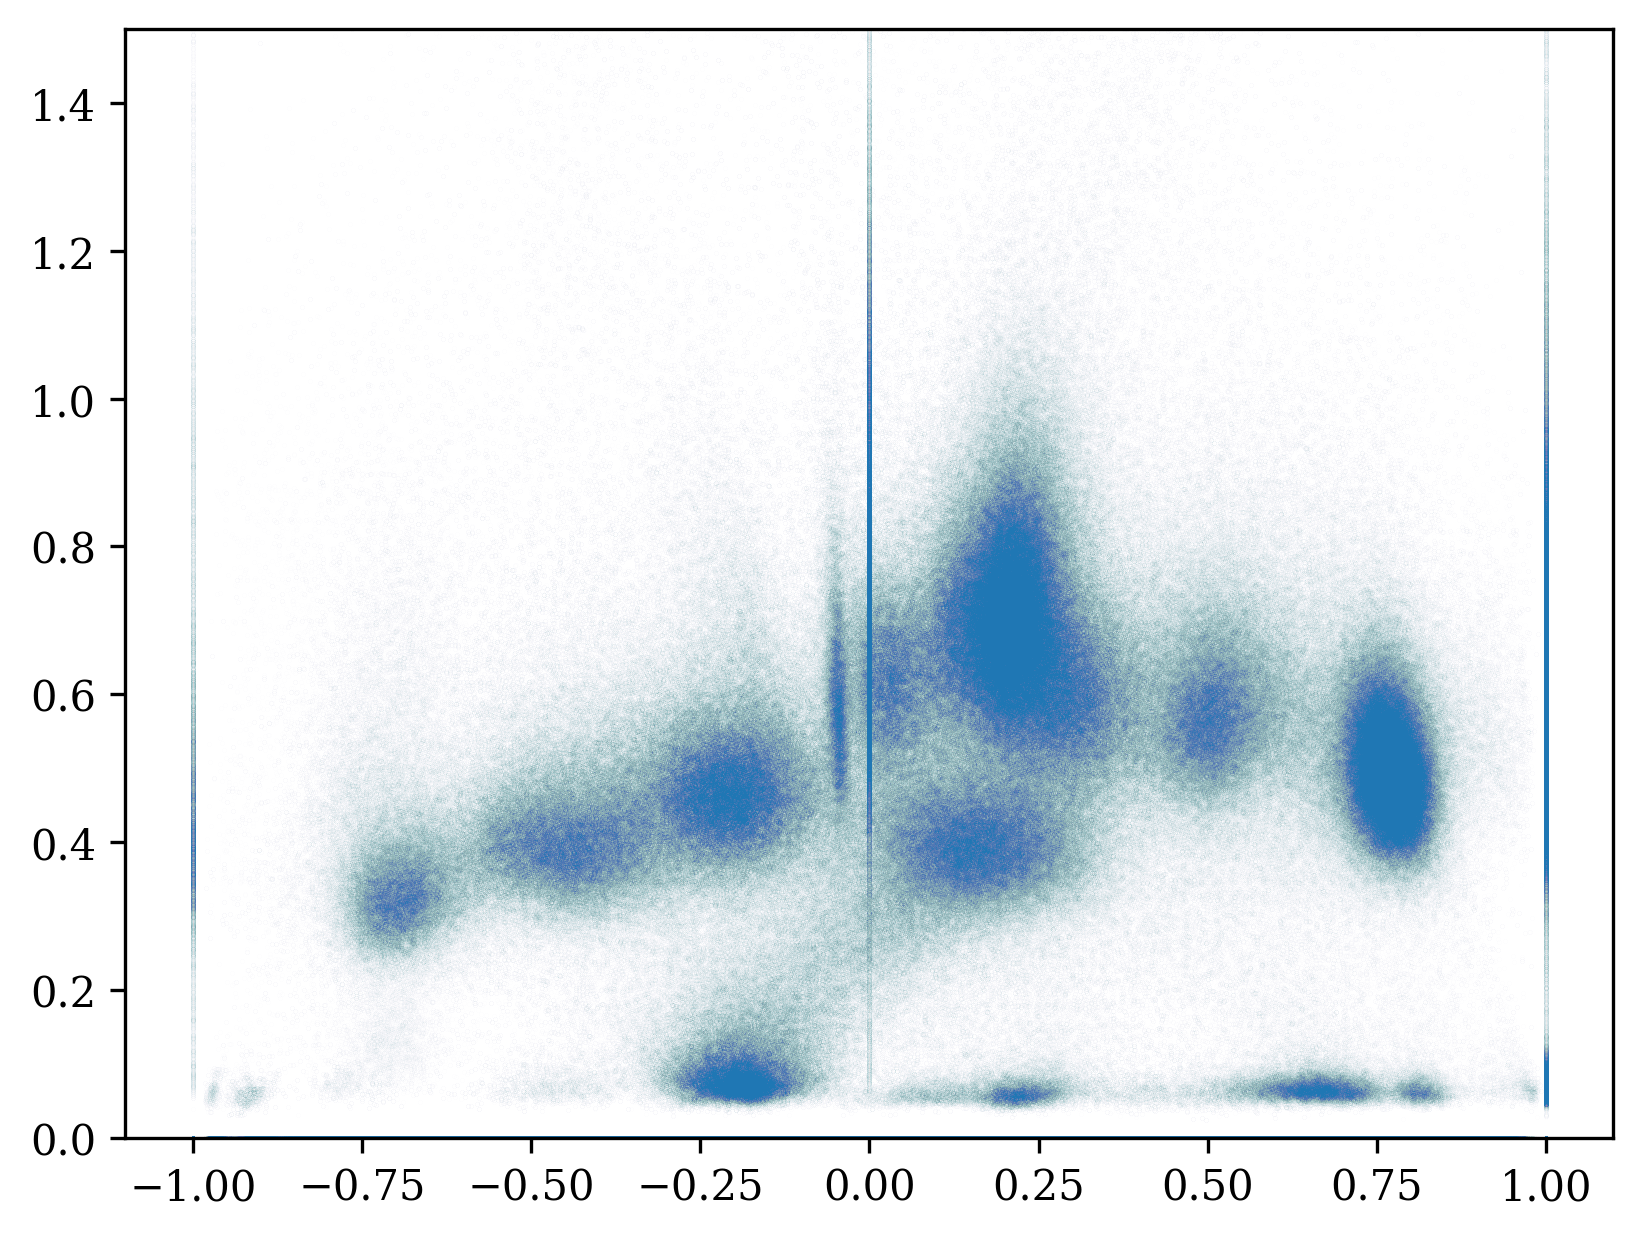

In [60]:
plt.scatter(intensity_all['Y_coor'],intensity_all['G/A'], s=0.0003,alpha=0.08,linewidths=None)
plt.ylim([0,1.5])
plt.savefig(read_dir/'0G_1G.jpg')

In [61]:
intensity_low = intensity_all[intensity_all['G/A']<=0.1]
intensity_high = intensity_all[intensity_all['G/A']>=0.2]

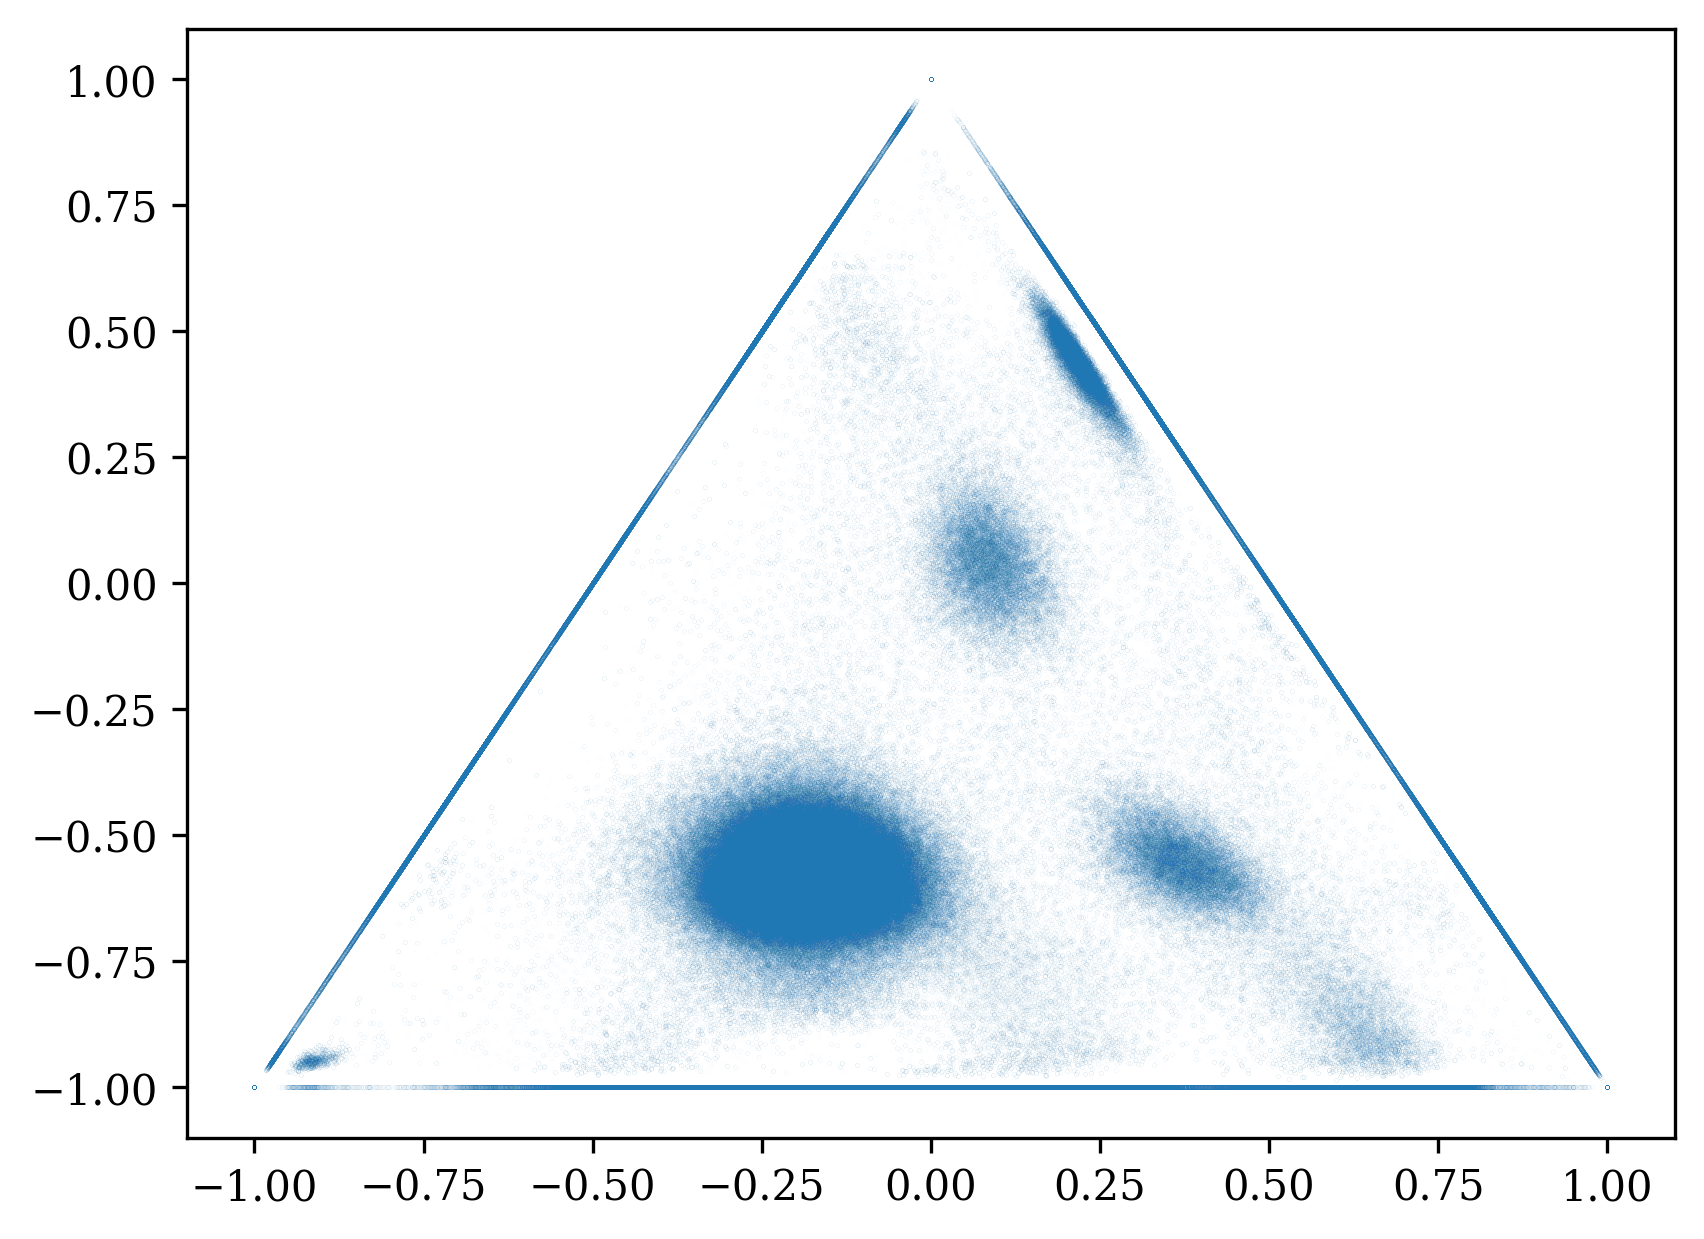

In [62]:
plt.scatter(intensity_low['Y_coor'],intensity_low['X_coor'],s=0.0009,alpha=0.15,linewidths=None)
plt.savefig(read_dir/'triangle_0G.jpg')

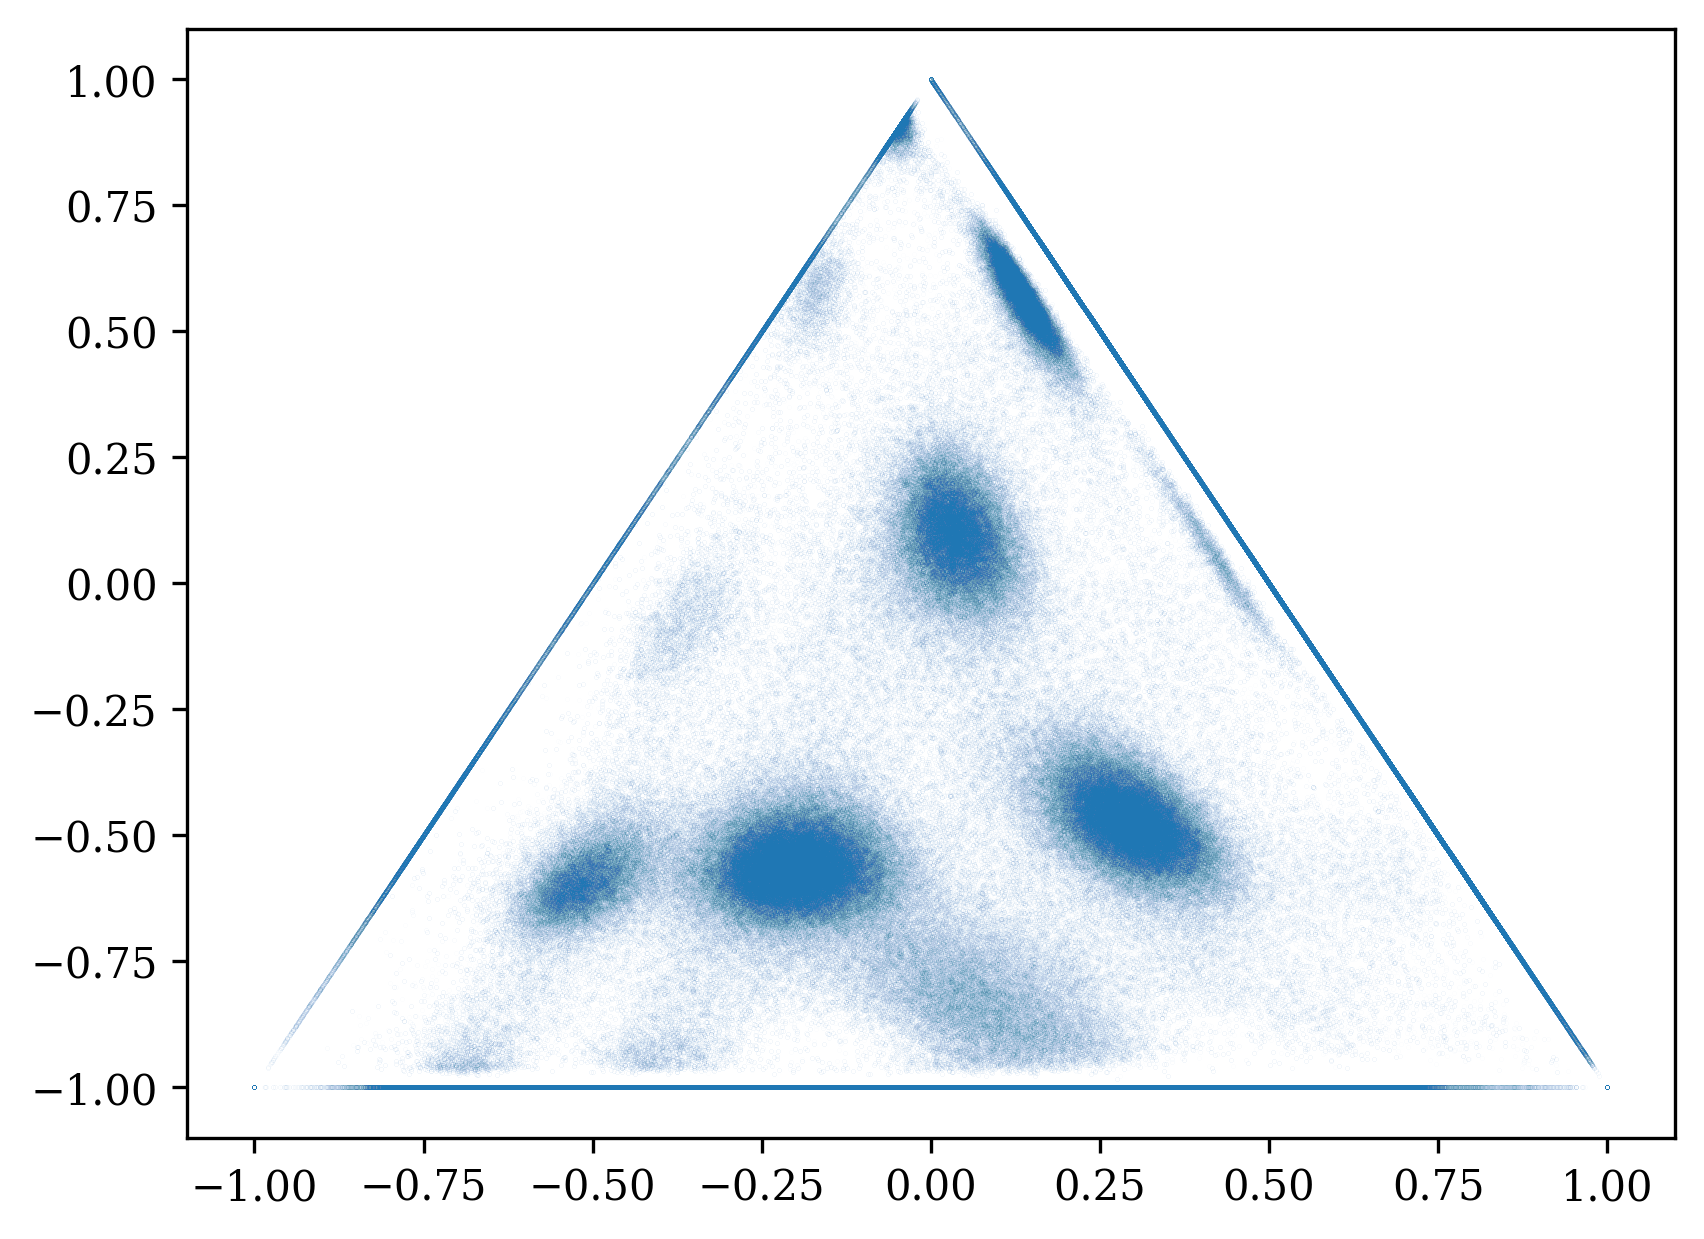

In [63]:
plt.scatter(intensity_high['Y_coor'],intensity_high['X_coor'],s=0.0009,alpha=0.08,linewidths=None)
plt.savefig(read_dir/'triangle_1G.jpg')

In [64]:
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema


def plot_freq(intensity, colorline, layer='1G', layer_threshold=0.25, order=5, contraction=0, vlines=True, curvefit_range=None, curvefit_p0=None,curvefit_pvalue=0.05, curvefit_colorset=['red', 'yellow', 'green'], save=False, read_dir=None):
    '''
    Plot a frequency plot.

    Parameters
    -----------
    intensity: pandas dataframe.
    colorline: projection line. 'RY', 'RB' or 'BY'.
    layer: the 4th color. '0G' or '1G'.
    layer_threshold: threshold of the 4th color. For '0G', it is the upper limit. For '1G', it is the lower limit.
    order: how many points on each side to use for the comparison to consider. For details, see scipy.signal.argrelextrema.
    contraction: distance between two peaks (= contraction*2). 
    vlines: whether to plot peak boundaries or not.
    curvefit_range: peak range to fit curve.
    curvefit_p0: initial guess for the parameters (length N). For details, see scipy.optimize.curve_fit.
    save: whether to save the plot alone.
    read_dir: 
    '''
    
    def gaussian(x, mu, sigma, A):
        return A*np.exp(-(x-mu)**2/(2*(sigma**2)))

    def mixgaussian(x, mu1, mu2, mu3, sigma1, sigma2, sigma3, A1, A2, A3):
        return gaussian(x, mu1, sigma1, A1) + gaussian(x, mu2, sigma2, A2) + gaussian(x, mu3, sigma3, A3)

    if layer == '0G':
        intensity = intensity[intensity['G/A'] <= layer_threshold]
    elif layer == '1G':
        intensity = intensity[intensity['G/A'] >= layer_threshold]

    if colorline == 'RY':
        intensity = intensity[intensity['B/A'] == 0] 
        intensity = intensity['R/A'] - intensity['Ye/A']
    elif colorline == 'RB':
        intensity = intensity[intensity['Ye/A'] == 0]
        intensity = intensity['R/A'] - intensity['B/A']
    elif colorline == 'BY':
        intensity = intensity[intensity['R/A'] == 0]
        intensity = intensity['B/A'] - intensity['Ye/A']

    hist = plt.hist(pd.DataFrame(intensity), bins = 200, log=True)
    freq, bins = hist[0], hist[1]
    extrema_less = argrelextrema(freq, np.less, order=order)[0] # assuming two side have 0, execute this code, or skip it
    bins_less = [(bins[extrema_less[i-1]+1]+contraction, bins[extrema_less[i]]-contraction) if i>0 else (bins[0], bins[1]) for i in range(len(extrema_less))]
    bins_less.append((bins[-2], bins[-1]))
    print('Peaks range of', colorline, bins_less)

    if vlines:
        plt.vlines([i[0] for i in bins_less], 0, 10000, linestyles='dashed', colors='red')
        plt.vlines([i[1] for i in bins_less], 0, 10000, linestyles='dashed', colors='green')

    if curvefit_range:
        confidence = 1 - curvefit_pvalue
        if confidence == 0.9: z = 1.28
        elif confidence == 0.95: z = 1.64

        start_idx, end_idx = curvefit_range[0], curvefit_range[1]
        bins_ = (bins[1:] + bins[:-1])/2 # for len(bins_) == len(freq)
        popt, pcov = curve_fit(mixgaussian, bins_[start_idx:end_idx], freq[start_idx:end_idx], p0=curvefit_p0, maxfev=1000000)

        # plot fitting curve separately: curve 1, curve 2, curve 3
        # curve 1
        mu, sigma, A = popt[0], popt[3], popt[6]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[0])
        print('Gaussian Curve 1: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 2
        mu, sigma, A = popt[1], popt[4], popt[7]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[1])
        print('Gaussian Curve 2: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])
        # curve 3
        mu, sigma, A = popt[2], popt[5], popt[8]
        plt.plot(bins_, gaussian(bins_, mu=mu, sigma=sigma, A=A), color=curvefit_colorset[2])
        print('Gaussian Curve 3: {A:.2f}*np.exp(-(x-{mu:.2f})**2/(2*({sigma:.2f}**2)))'.format(mu=mu, sigma=sigma, A=A))
        print(confidence*100, '% confidence interval:', [mu-z*sigma, mu+z*sigma])

    if save:
        if read_dir: plt.savefig(read_dir / (colorline+'_'+layer+'.jpg'))
        else: print('Input a read_dir to save the plot.\n') # Maybe a warning or error

Peaks range of RY [(-1.0, -0.99), (-0.87, -0.75), (-0.74, -0.16999999999999993), (-0.16000000000000003, 0.24), (0.25, 0.8600000000000001), (0.99, 1.0)]
Peaks range of RB [(-1.0, -0.99), (-0.98, -0.36), (-0.35, 0.10000000000000009), (0.99, 1.0)]
Peaks range of BY [(-1.0, -0.99), (-0.79, -0.06999999999999995), (-0.05999999999999994, 0.40000000000000013), (0.4099999999999999, 0.8800000000000001), (0.8900000000000001, 0.98), (0.99, 1.0)]


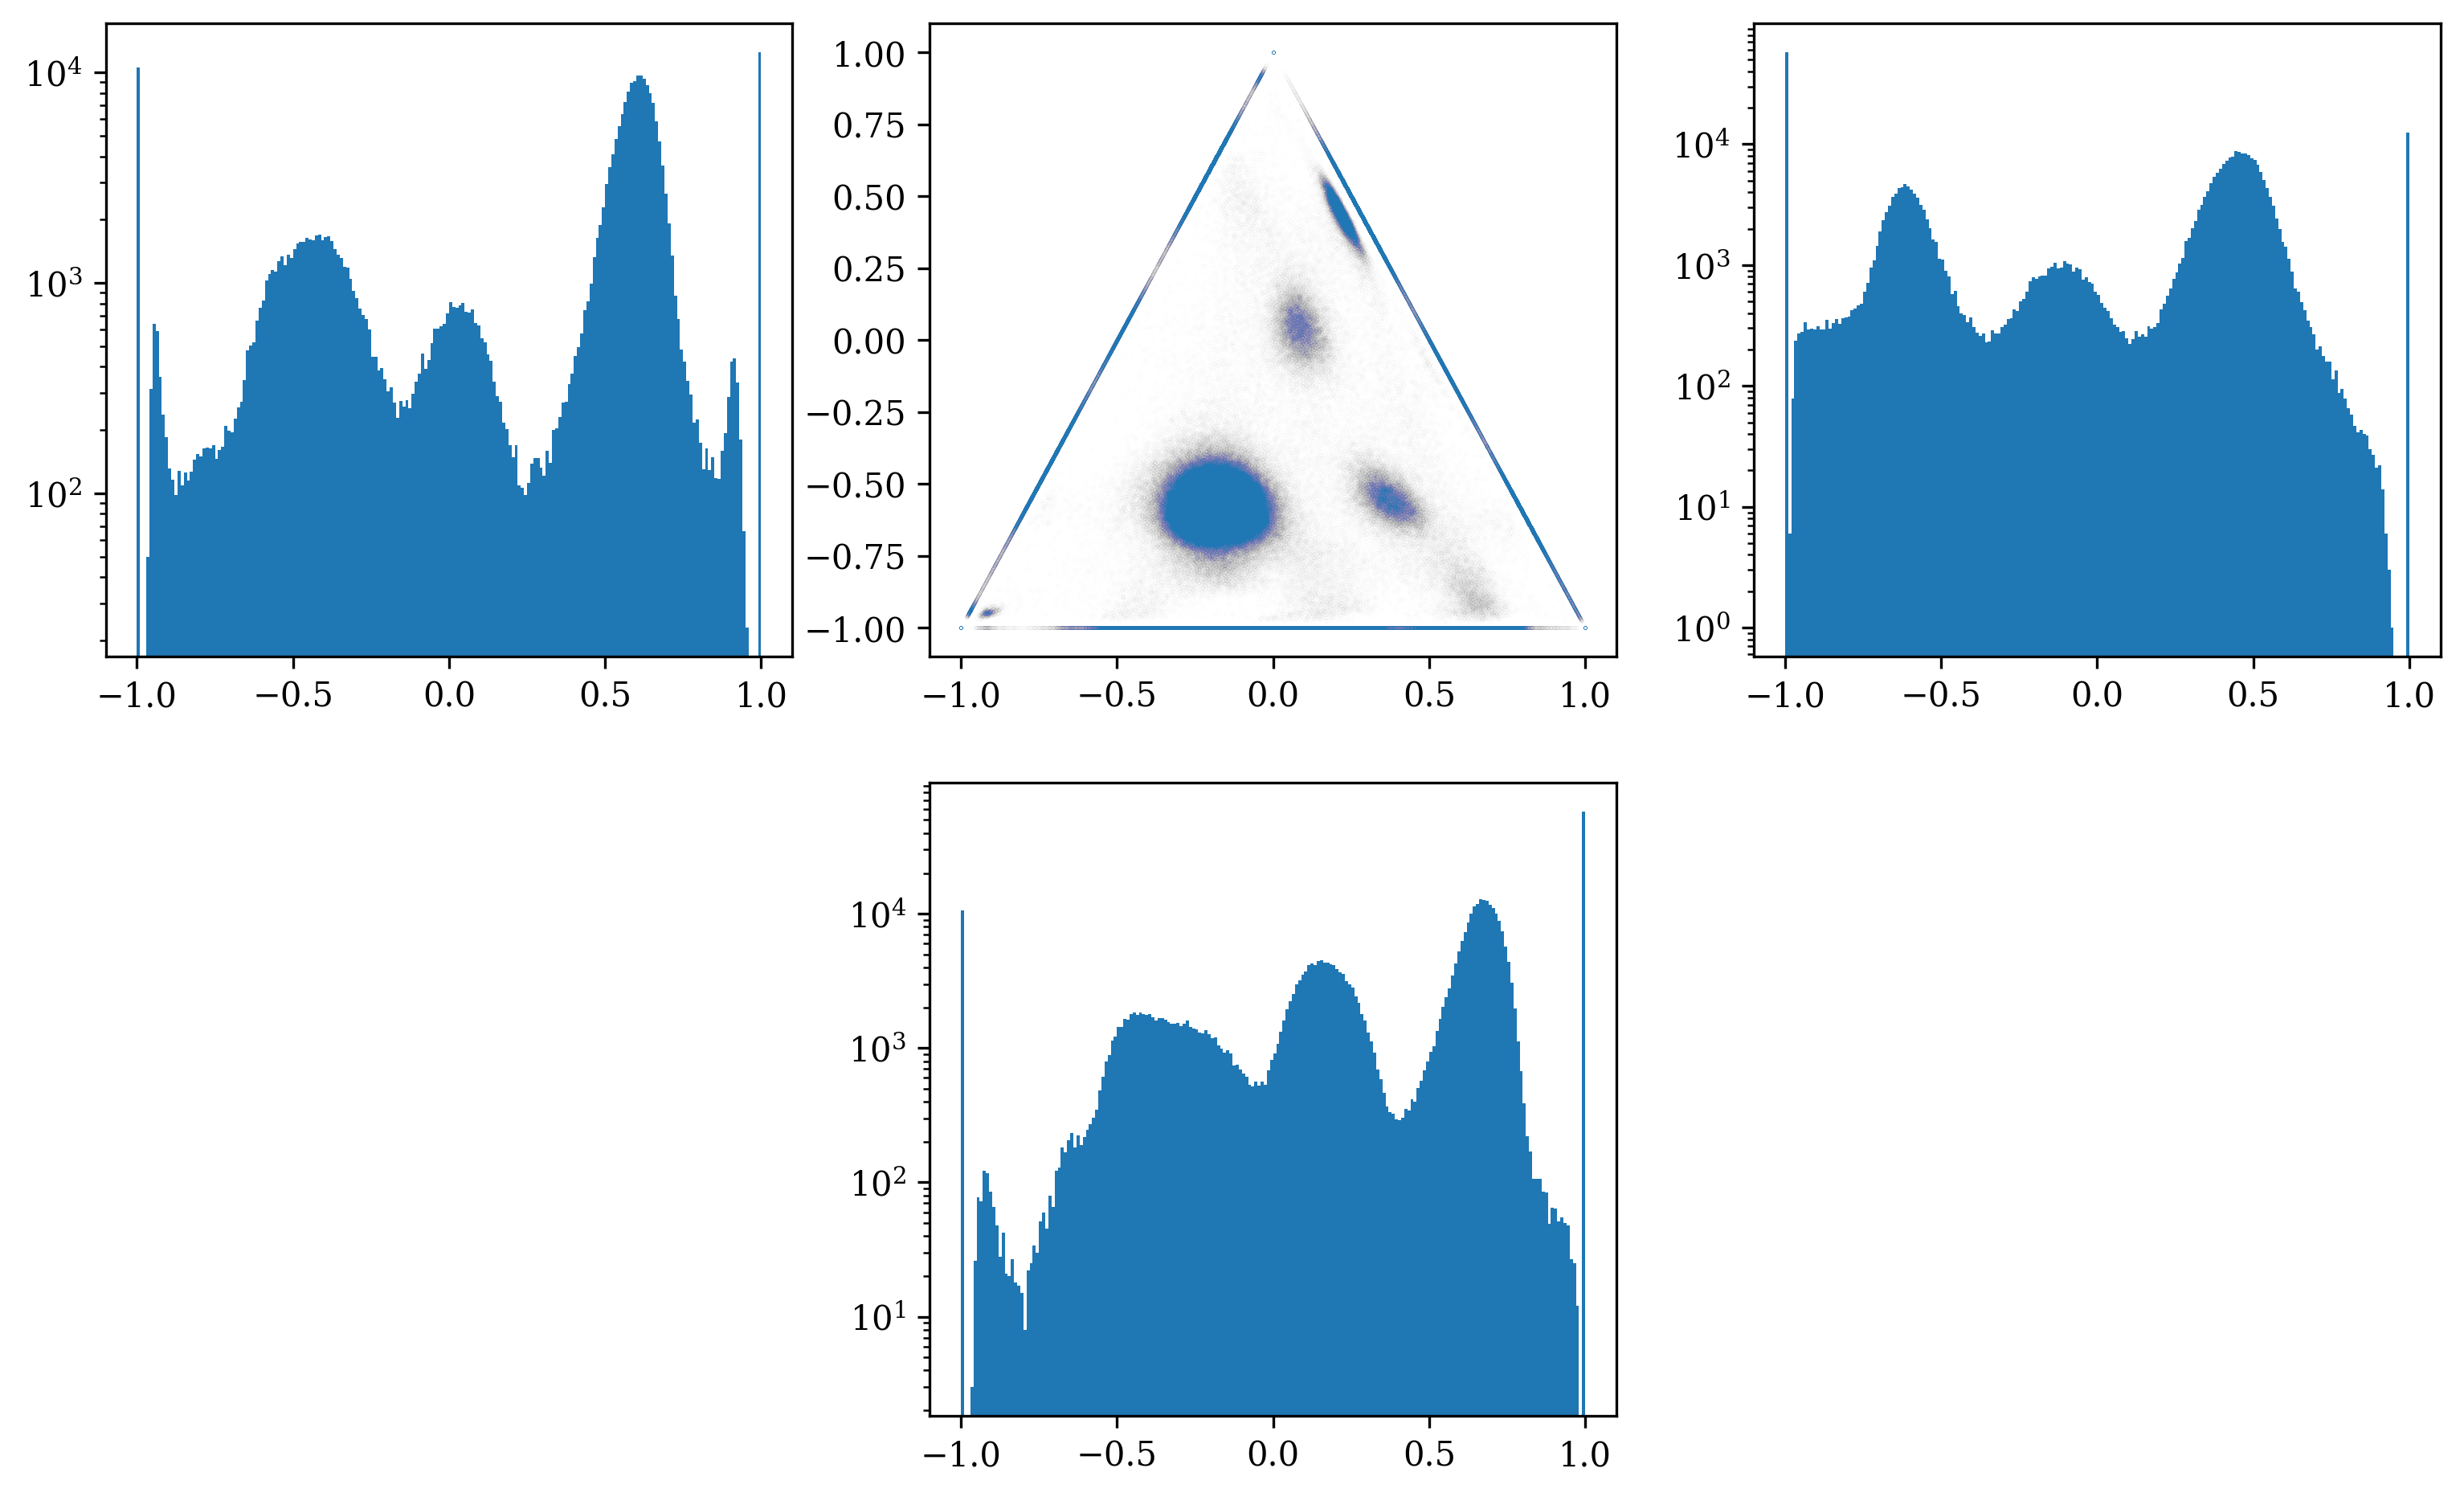

In [65]:
# plots: scatter + frequency plot in three dimension
fig = plt.figure()    # 生成新的画布fig
fig.set_size_inches(12.5, 7.5)     # 调整画布为合适大小

p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_low['Y_coor'], intensity_low['X_coor'], s=0.00009, alpha=0.08, linewidths=None)
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='0G', layer_threshold=0.1, vlines=False,curvefit_pvalue=0.05)#, curvefit_range=(10,190), curvefit_p0=(-0.5, 0, 0.5, 0.1, 0.1, 0.1, 1500, 500, 22000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='0G', layer_threshold=0.1, vlines=False,curvefit_pvalue=0.1)#, curvefit_range=(10,190), curvefit_p0=(-0.7, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='0G', layer_threshold=0.1, vlines=False,curvefit_pvalue=0.1, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')

plt.show()

Peaks range of RY [(-1.0, -0.99), (-0.8200000000000001, -0.20999999999999996), (-0.19999999999999996, -0.030000000000000027), (-0.020000000000000018, 0.28), (0.29000000000000004, 0.75), (0.99, 1.0)]
Peaks range of RB [(-1.0, -0.99), (-0.98, -0.27), (-0.26, 0.26), (0.27, 0.9100000000000001), (0.99, 1.0)]
Peaks range of BY [(-1.0, -0.99), (-0.97, -0.56), (-0.55, -0.13), (-0.12, 0.41999999999999993), (0.99, 1.0)]


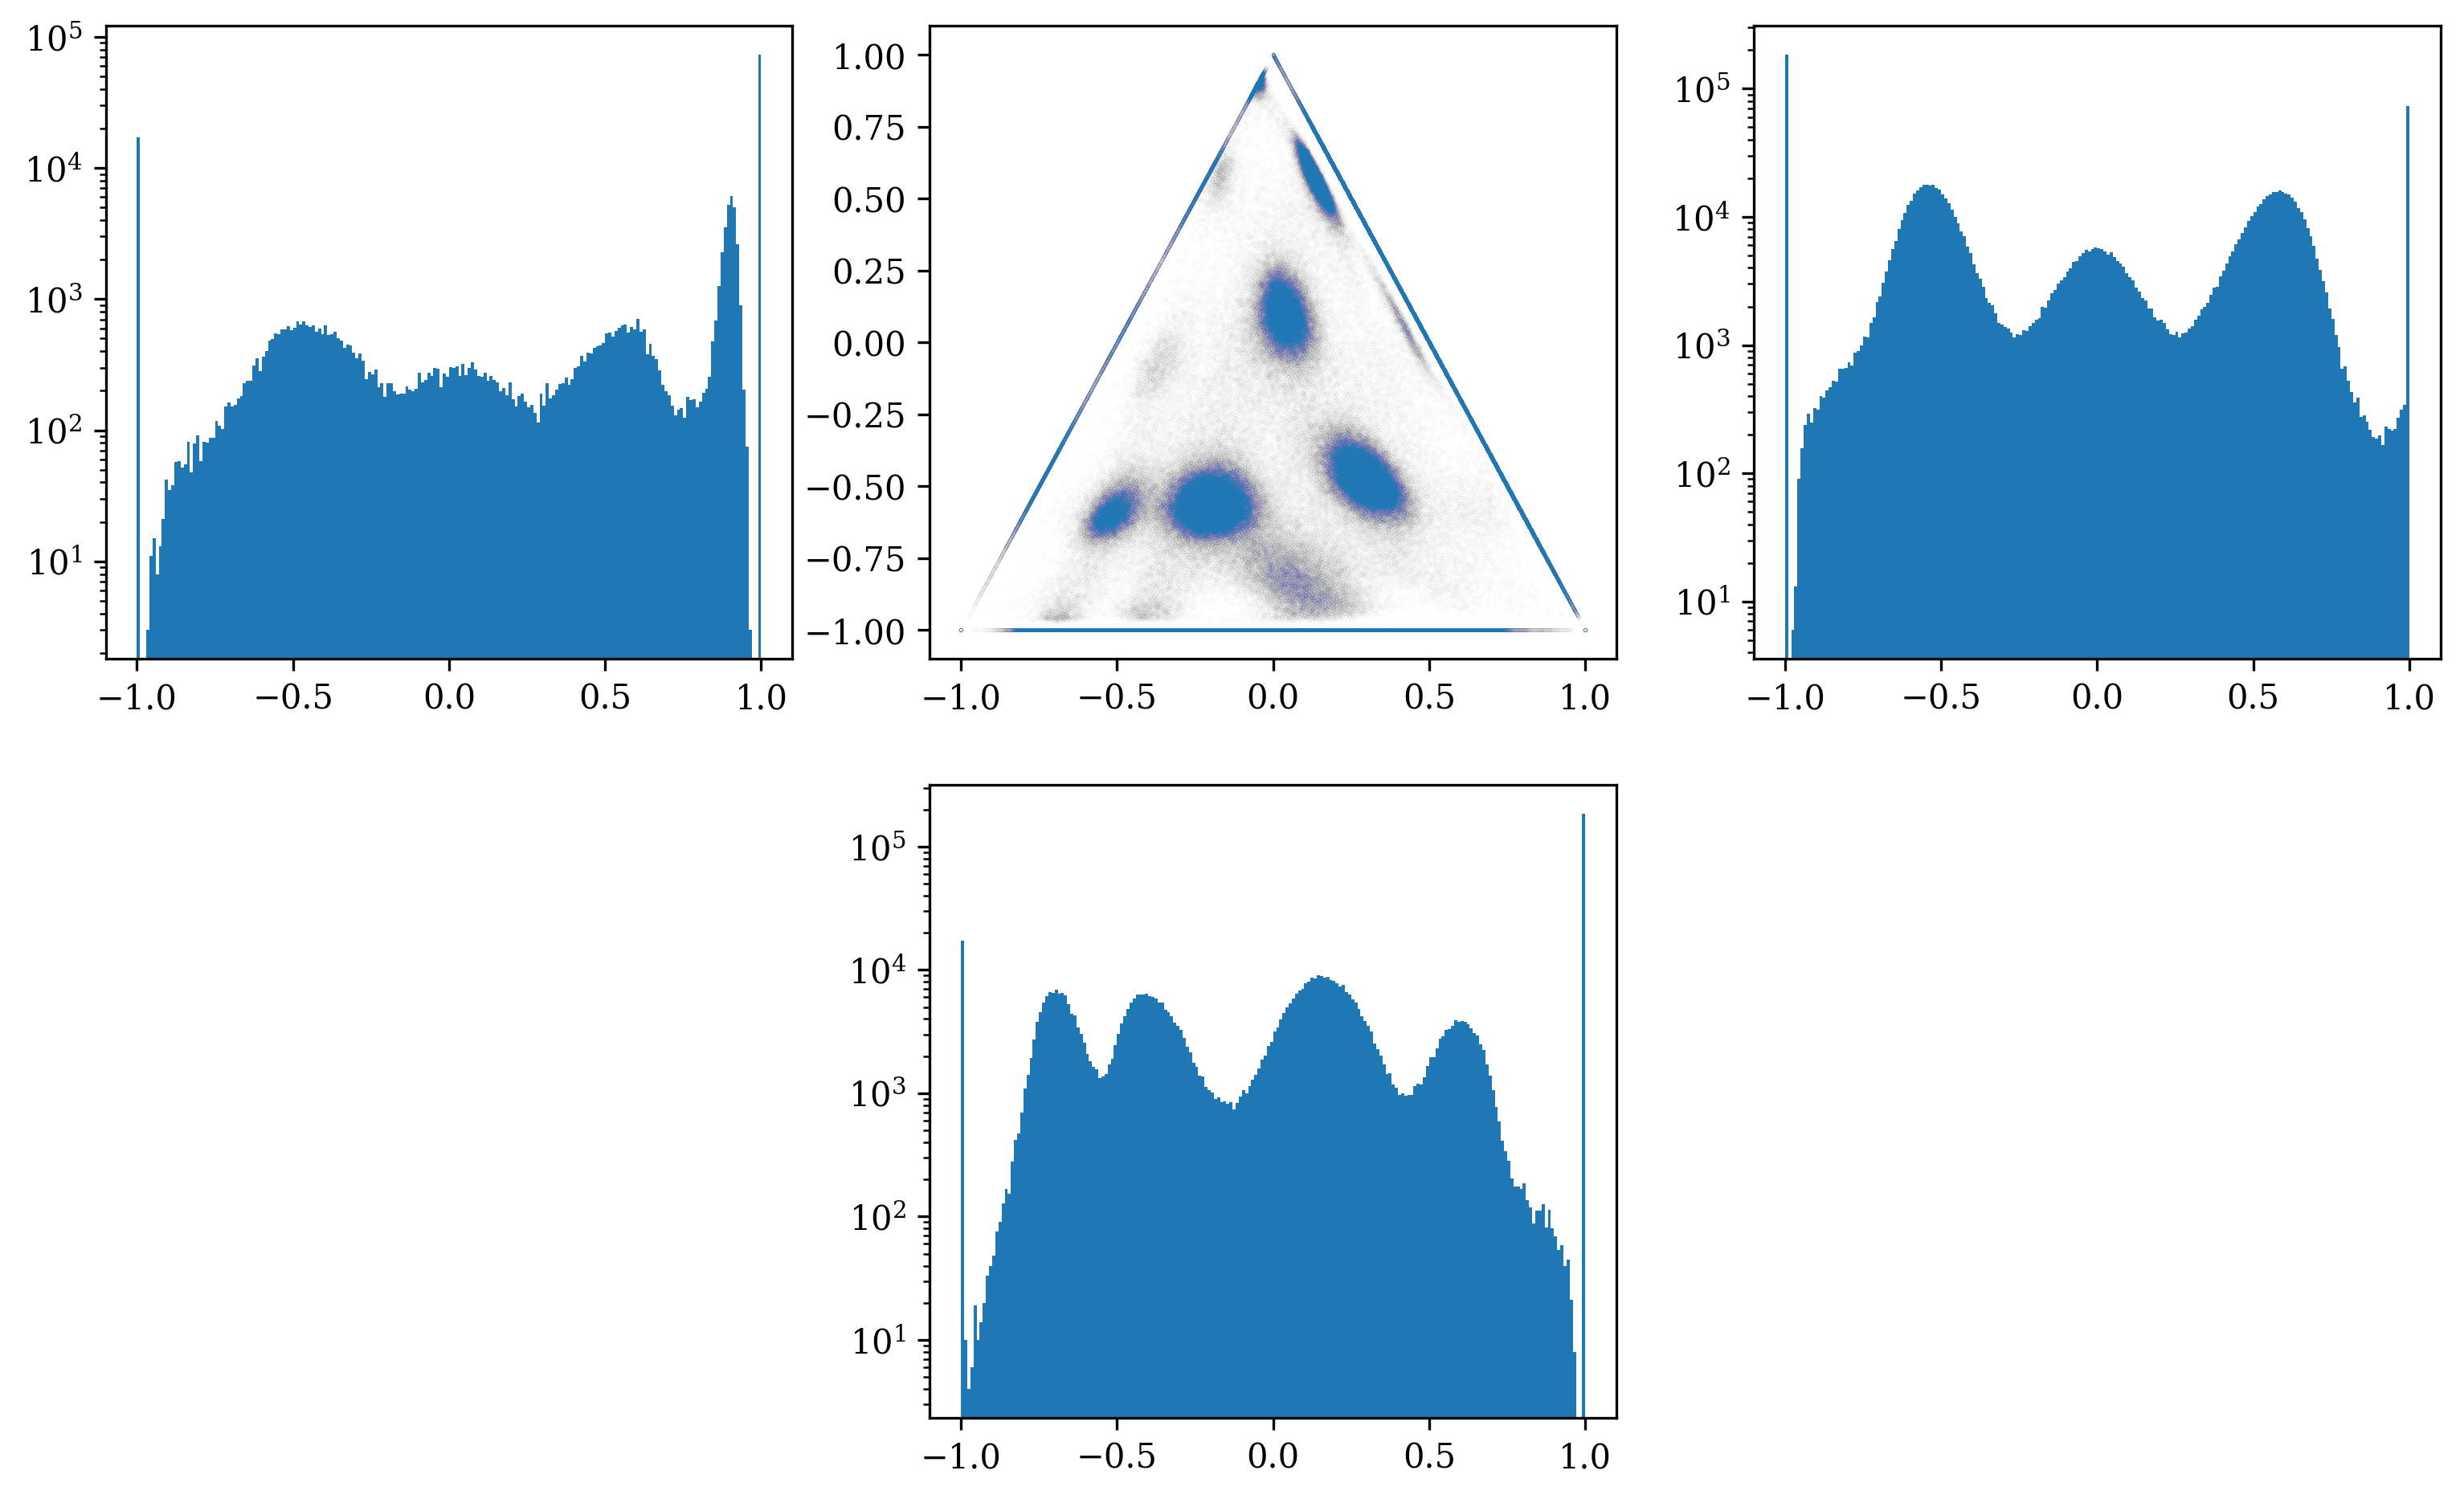

In [66]:
# plots: scatter + frequency plot in three dimension
fig = plt.figure()
fig.set_size_inches(12.5, 7.5)
p0 = [-1, 1, 1, 1, 3, 3]
plt.subplot(232)  # scatter
plt.scatter(intensity_high['Y_coor'], intensity_high['X_coor'], s=0.00009, alpha=0.08, linewidths=None)
plt.subplot(231)   # red-yellow
plot_freq(intensity_all, colorline='RY', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,160), curvefit_p0=(-0.55, -0.05, 0.45, 0.1, 0.1, 0.1, 1000, 1000, 6000),curvefit_colorset=['gold', 'darkorange', 'orangered'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(233)   # red-blue
plot_freq(intensity_all, colorline='RB', layer='1G', layer_threshold=0.2, vlines=False)#, curvefit_range=(10,160), curvefit_p0=(-0.6, -0.25, 0.35, 0.1, 0.1, 0.1, 5000, 5000, 5000),curvefit_colorset=['darkviolet', 'magenta', 'deeppink'])#, save=True, read_dir=src_dir / 'readout')
plt.subplot(235)   # yellow-blue
plot_freq(intensity_all, colorline='BY', layer='1G', layer_threshold=0.2, vlines=False, save=True, read_dir=src_dir / 'readout')#, curvefit_range=(20,190), curvefit_p0=(-0.4, 0.2, 0.6, 0.1, 0.1, 0.1, 3000, 10000, 20000),curvefit_colorset=['greenyellow', 'springgreen', 'deepskyblue'], save=True, read_dir=src_dir / 'readout')
plt.show()

## manual classification

### threshold by tissue

Here, we adjusted different threshold values for different samples for better gene calling effects. Choose appropriate set for specific data.

In [67]:
# # SPEPCIFIC FOR E12.5
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.15)&(intensity_all.Y_coor >= -0.575)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.35)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.675)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.05)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.9)&(intensity_all.Y_coor >= 0.8)&(intensity_all.Y_coor <= 0.95)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.3)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.05),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.95)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.875)&(intensity_all.Y_coor <= -0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.25)&(intensity_all.X_coor <= 0.05)&(intensity_all.Y_coor >= 0.475)&(intensity_all.Y_coor <= 0.625)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.3)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0.25)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.15),'Gene'] = 'PRISM_30'

In [68]:
# # for E 13.5
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.15)&(intensity_all.Y_coor >= -0.575)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.7)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.15)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.55)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.775)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.25)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.3)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.8)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16' #0.95_2_7
# intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.875)&(intensity_all.Y_coor <= -0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.3)&(intensity_all.X_coor <= 0.1)&(intensity_all.Y_coor >= 0.45)&(intensity_all.Y_coor <= 0.65)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.3)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0.2)&(intensity_all.X_coor >= -0.2)&(intensity_all.Y_coor >= -0.1)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.35)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_30'

In [69]:
# # for E 13.5 1_16
# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= 0.2)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.35)&(intensity_all.Y_coor >= -0.675)&(intensity_all.Y_coor <= -0.55)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= -0.95)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= -0.975)&(intensity_all.Y_coor <= -0.8)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor <= -0.8)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor >= -0.5)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.99)&(intensity_all.Y_coor >= 0.6)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor <= -0.75)&(intensity_all.X_coor >= -0.95)&(intensity_all.Y_coor >= 0.875)&(intensity_all.Y_coor <= 0.975)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor <= -0.3)&(intensity_all.X_coor >= -0.6)&(intensity_all.Y_coor >= 0.65)&(intensity_all.Y_coor <= 0.8)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor <= 0.5)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.55)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.5)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.35)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor <= -0.6)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor <= -0.7)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.4)&(intensity_all.Y_coor <= 0.6)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= 0.95)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= 0.25)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= -0.7)&(intensity_all.Y_coor <= -0.35)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= -0.9)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= -0.95)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= -0.95)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= 0.8)&(intensity_all.Y_coor <= 0.975)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= -0.55)&(intensity_all.X_coor <= 0)&(intensity_all.Y_coor >= 0.5)&(intensity_all.Y_coor <= 0.775)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= 0.1)&(intensity_all.X_coor <= 0.6)&(intensity_all.Y_coor >= 0.2)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor <= 0)&(intensity_all.X_coor >= -0.35)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.65)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.6)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.55)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_30'

In [70]:
# for E 13.5 2_3
intensity_all['Gene'] = 'Other'
intensity_all.loc[(intensity_all.X_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_1'
intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.3)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_2'
intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.15)&(intensity_all.Y_coor >= -0.575)&(intensity_all.Y_coor <= -0.45)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_3'
intensity_all.loc[(intensity_all.X_coor >= -0.8)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.9)&(intensity_all.Y_coor <= -0.7)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_4'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.98)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_5'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.6)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_6'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] <= 0.18),'Gene'] = 'PRISM_7'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_8'
intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_9'
intensity_all.loc[(intensity_all.X_coor <= -0.55)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.775)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_10'
intensity_all.loc[(intensity_all.X_coor <= -0.1)&(intensity_all.X_coor >= -0.4)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.7)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_11'
intensity_all.loc[(intensity_all.X_coor <= 0.7)&(intensity_all.X_coor >= 0.1)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.45)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_12'
intensity_all.loc[(intensity_all.X_coor <= 0.25)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= 0)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] <= 0.18),'Gene'] = 'PRISM_13'
intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.8)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0.1)&(intensity_all['G/A'] <= 0.1),'Gene'] = 'PRISM_14'
intensity_all.loc[(intensity_all.X_coor <= -0.5)&(intensity_all.X_coor >= -0.85)&(intensity_all.Y_coor >= 0.3)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] <= 0.18),'Gene'] = 'PRISM_15'

intensity_all.loc[(intensity_all.X_coor >= 0.8)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_16' #0.95_2_7
intensity_all.loc[(intensity_all.X_coor >= 0.4)&(intensity_all.X_coor <= 0.75)&(intensity_all.Y_coor >= -0.325)&(intensity_all.Y_coor <= -0.125)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_17'
intensity_all.loc[(intensity_all.X_coor <= 0.1)&(intensity_all.X_coor >= -0.1)&(intensity_all.Y_coor >= -0.55)&(intensity_all.Y_coor <= -0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_18'
intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.4)&(intensity_all.Y_coor >= -0.875)&(intensity_all.Y_coor <= -0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_19'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= -0.6)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_20'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= -0.4)&(intensity_all.Y_coor <= -0.1)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_21'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_22'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.55)&(intensity_all.Y_coor <= 0.9)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_23'
intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= 0.999)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_24'
intensity_all.loc[(intensity_all.X_coor >= -0.85)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= 0.75)&(intensity_all.Y_coor <= 0.925)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_25'
intensity_all.loc[(intensity_all.X_coor >= -0.3)&(intensity_all.X_coor <= 0.1)&(intensity_all.Y_coor >= 0.45)&(intensity_all.Y_coor <= 0.65)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_26'
intensity_all.loc[(intensity_all.X_coor >= 0.3)&(intensity_all.X_coor <= 0.8)&(intensity_all.Y_coor >= 0.1)&(intensity_all.Y_coor <= 0.4)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_27'
intensity_all.loc[(intensity_all.X_coor <= 0.2)&(intensity_all.X_coor >= -0.2)&(intensity_all.Y_coor >= -0.1)&(intensity_all.Y_coor <= 0.25)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_28'
intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.5)&(intensity_all.Y_coor >= -0.35)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_29'
intensity_all.loc[(intensity_all.X_coor >= -0.75)&(intensity_all.X_coor <= -0.35)&(intensity_all.Y_coor >= 0.25)&(intensity_all.Y_coor <= 0.5)&(intensity_all['G/A'] >= 0.2),'Gene'] = 'PRISM_30'

In [71]:
# #E14.5 New version

# G_Low_Thre = 0.15
# G_High_Thre = 0.25

# PRISM_1_XL = 0.82

# PRISM_2_XL = 0.18
# PRISM_2_XH = 0.78

# PRISM_3_XL = -0.32
# PRISM_3_XH = 0.17

# PRISM_4_XL = -0.83
# PRISM_4_XH = -0.34

# PRISM_5_XH = -0.99

# PRISM_6_XL = -0.75
# PRISM_6_XH = -0.32

# PRISM_7_XL = -0.26
# PRISM_7_XH = 0.38

# PRISM_8_XL = 0.48
# PRISM_8_XH = 0.85

# PRISM_9_XL = 0.99

# PRISM_10_XL = -0.85
# PRISM_10_XH = -0.4

# PRISM_11_XL = -0.35
# PRISM_11_XH = 0.16

# PRISM_12_XL = 0.17
# PRISM_12_XH = 0.7 #

# PRISM_13_XL = -0.25
# PRISM_13_XH = 0.22
# PRISM_13_YL = 0
# PRISM_13_YH = 0.24

# PRISM_14_XL = -0.75
# PRISM_14_XH = -0.5
# PRISM_14_YL = -0.5
# PRISM_14_YH = 0

# PRISM_15_XL = -0.75
# PRISM_15_XH = -0.5
# PRISM_15_YL = 0.25
# PRISM_15_YH = 0.5

# PRISM_16_XL = 0.76 # 0.78

# PRISM_17_XL = 0.15
# PRISM_17_XH = 0.73

# PRISM_18_XL = -0.36
# PRISM_18_XH = 0.11 #

# PRISM_19_XL = -0.8
# PRISM_19_XH = -0.36

# PRISM_20_XH = -0.65 #contract!

# PRISM_21_XL = -0.58
# PRISM_21_XH = -0.16

# PRISM_22_XL = -0.15
# PRISM_22_XH = 0.1

# PRISM_23_XL = 0.15
# PRISM_23_XH = 0.6

# PRISM_24_XL = 0.99

# PRISM_25_XL = -0.8 #
# PRISM_25_XH = -0.29

# PRISM_26_XL = -0.28
# PRISM_26_XH = 0.3

# PRISM_27_XL = 0.41
# PRISM_27_XH = 0.8 #

# PRISM_28_XL = -0.25
# PRISM_28_XH = 0.22
# PRISM_28_YL = -0.1
# PRISM_28_YH = 0.18

# PRISM_29_XL = -0.8
# PRISM_29_XH = -0.5
# PRISM_29_YL = -0.4
# PRISM_29_YH = 0

# PRISM_30_XL = -0.75
# PRISM_30_XH = -0.45
# PRISM_30_YL = 0.1
# PRISM_30_YH = 0.5

# PRISM_2_XL_Range = 0.9*PRISM_2_XL+0.1*PRISM_2_XH
# PRISM_2_XH_Range = 0.1*PRISM_2_XL+0.9*PRISM_2_XH
# PRISM_3_XL_Range = 0.9*PRISM_3_XL+0.1*PRISM_3_XH
# PRISM_3_XH_Range = 0.1*PRISM_3_XL+0.9*PRISM_3_XH
# PRISM_4_XL_Range = 0.9*PRISM_4_XL+0.1*PRISM_4_XH
# PRISM_4_XH_Range = 0.1*PRISM_4_XL+0.9*PRISM_4_XH
# PRISM_6_XL_Range = 0.9*PRISM_6_XL+0.1*PRISM_6_XH
# PRISM_6_XH_Range = 0.1*PRISM_6_XL+0.9*PRISM_6_XH
# PRISM_7_XL_Range = 0.9*PRISM_7_XL+0.1*PRISM_7_XH
# PRISM_7_XH_Range = 0.1*PRISM_7_XL+0.9*PRISM_7_XH
# PRISM_8_XL_Range = 0.9*PRISM_8_XL+0.1*PRISM_8_XH
# PRISM_8_XH_Range = 0.1*PRISM_8_XL+0.9*PRISM_8_XH
# PRISM_10_XL_Range = 0.9*PRISM_10_XL+0.1*PRISM_10_XH
# PRISM_10_XH_Range = 0.1*PRISM_10_XL+0.9*PRISM_10_XH
# PRISM_11_XL_Range = 0.9*PRISM_11_XL+0.1*PRISM_11_XH
# PRISM_11_XH_Range = 0.1*PRISM_11_XL+0.9*PRISM_11_XH
# PRISM_12_XL_Range = 0.9*PRISM_12_XL+0.1*PRISM_12_XH
# PRISM_12_XH_Range = 0.1*PRISM_12_XL+0.9*PRISM_12_XH

# PRISM_17_XL_Range = 0.9*PRISM_17_XL+0.1*PRISM_17_XH
# PRISM_17_XH_Range = 0.1*PRISM_17_XL+0.9*PRISM_17_XH
# PRISM_18_XL_Range = 0.9*PRISM_18_XL+0.1*PRISM_18_XH
# PRISM_18_XH_Range = 0.1*PRISM_18_XL+0.9*PRISM_18_XH
# PRISM_19_XL_Range = 0.9*PRISM_19_XL+0.1*PRISM_19_XH
# PRISM_19_XH_Range = 0.1*PRISM_19_XL+0.9*PRISM_19_XH
# PRISM_21_XL_Range = 0.9*PRISM_21_XL+0.1*PRISM_21_XH
# PRISM_21_XH_Range = 0.1*PRISM_21_XL+0.9*PRISM_21_XH
# PRISM_22_XL_Range = 0.9*PRISM_22_XL+0.1*PRISM_22_XH
# PRISM_22_XH_Range = 0.1*PRISM_22_XL+0.9*PRISM_22_XH
# PRISM_23_XL_Range = 0.9*PRISM_23_XL+0.1*PRISM_23_XH
# PRISM_23_XH_Range = 0.1*PRISM_23_XL+0.9*PRISM_23_XH
# PRISM_25_XL_Range = 0.9*PRISM_25_XL+0.1*PRISM_25_XH
# PRISM_25_XH_Range = 0.1*PRISM_25_XL+0.9*PRISM_25_XH
# PRISM_26_XL_Range = 0.9*PRISM_26_XL+0.1*PRISM_26_XH
# PRISM_26_XH_Range = 0.1*PRISM_26_XL+0.9*PRISM_26_XH
# PRISM_27_XL_Range = 0.9*PRISM_27_XL+0.1*PRISM_27_XH
# PRISM_27_XH_Range = 0.1*PRISM_27_XL+0.9*PRISM_27_XH

# intensity_all['Gene'] = 'Other'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_1_XL)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_1'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_2_XL_Range)&(intensity_all.X_coor <= PRISM_2_XH_Range)&(intensity_all.Y_coor >= (PRISM_2_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_2_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_2'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_3_XL_Range)&(intensity_all.X_coor <= PRISM_3_XH_Range)&(intensity_all.Y_coor >= (PRISM_3_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_3_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_3'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_4_XL_Range)&(intensity_all.X_coor <= PRISM_4_XH_Range)&(intensity_all.Y_coor >= (PRISM_4_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_4_XH_Range-1)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_4'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_5_XH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_5'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_6_XL_Range)&(intensity_all.Y_coor <= PRISM_6_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_6'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_7_XL_Range)&(intensity_all.Y_coor <= PRISM_7_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_7'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_8_XL_Range)&(intensity_all.Y_coor <= PRISM_8_XH_Range)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_8'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_9_XL)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_9'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_10_XL_Range)&(intensity_all.X_coor <= PRISM_10_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_10_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_10_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_10'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_11_XL_Range)&(intensity_all.X_coor <= PRISM_11_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_11_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_11_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_11'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_12_XL_Range)&(intensity_all.X_coor <= PRISM_12_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_12_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_12_XL_Range)/2)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_12'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_13_XL)&(intensity_all.X_coor <= PRISM_13_XH)&(intensity_all.Y_coor >= PRISM_13_YL)&(intensity_all.Y_coor <= PRISM_13_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_13'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_14_XL)&(intensity_all.X_coor <= PRISM_14_XH)&(intensity_all.Y_coor >= PRISM_14_YL)&(intensity_all.Y_coor <= PRISM_14_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_14'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_15_XL)&(intensity_all.X_coor <= PRISM_15_XH)&(intensity_all.Y_coor >= PRISM_15_YL)&(intensity_all.Y_coor <= PRISM_15_YH)&(intensity_all['G/A'] <= G_Low_Thre),'Gene'] = 'PRISM_15'

# intensity_all.loc[(intensity_all.X_coor >= PRISM_16_XL)&(intensity_all.Y_coor <= 0)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_16'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_17_XL_Range)&(intensity_all.X_coor <= PRISM_17_XH)&(intensity_all.Y_coor >= (PRISM_17_XL_Range-1)/2)&(intensity_all.Y_coor <= (PRISM_17_XH_Range-1)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_17'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_18_XL_Range)&(intensity_all.X_coor <= PRISM_18_XH_Range)&(intensity_all.Y_coor >= (PRISM_18_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.3)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_18'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_19_XL_Range)&(intensity_all.X_coor <= PRISM_19_XH_Range)&(intensity_all.Y_coor >=  (PRISM_19_XL_Range-1)/2)&(intensity_all.Y_coor <= -0.48)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_19'

# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor <= PRISM_20_XH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_20'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_21_XL_Range)&(intensity_all.Y_coor <= PRISM_21_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_21'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_22_XL_Range)&(intensity_all.Y_coor <= PRISM_22_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_22'
# intensity_all.loc[(intensity_all.X_coor <= -0.9)&(intensity_all.Y_coor >= PRISM_23_XL_Range)&(intensity_all.Y_coor <= PRISM_23_XH_Range)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_23'
# intensity_all.loc[(intensity_all.X_coor <= -0.999)&(intensity_all.Y_coor >= PRISM_24_XL)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_24'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_25_XL_Range)&(intensity_all.X_coor <= PRISM_25_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_25_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_25_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_25'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_26_XL_Range)&(intensity_all.X_coor <= PRISM_26_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_26_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_26_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_26'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_27_XL_Range)&(intensity_all.X_coor <= PRISM_27_XH_Range)&(intensity_all.Y_coor >= (1-PRISM_27_XH_Range)/2)&(intensity_all.Y_coor <= (1-PRISM_27_XL_Range)/2)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_27'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_28_XL)&(intensity_all.X_coor <= PRISM_28_XH)&(intensity_all.Y_coor >= PRISM_28_YL)&(intensity_all.Y_coor <= PRISM_28_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_28'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_29_XL)&(intensity_all.X_coor <= PRISM_29_XH)&(intensity_all.Y_coor >= PRISM_29_YL)&(intensity_all.Y_coor <= PRISM_29_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_29'
# intensity_all.loc[(intensity_all.X_coor >= PRISM_30_XL)&(intensity_all.X_coor <= PRISM_30_XH)&(intensity_all.Y_coor >= PRISM_30_YL)&(intensity_all.Y_coor <= PRISM_30_YH)&(intensity_all['G/A'] >= G_High_Thre),'Gene'] = 'PRISM_30'
# intensity_all.loc[(intensity_all['G/A'] >= 10),'Gene'] = 'PRISM_31'

In [72]:
intensity_all[intensity_all['Gene'] == 'PRISM_30']

Y        X       R      Ye       G        B  Scaled_R  \
18200    12872.0   9487.0  3820.0  1785.0  1356.0  6242.00    3820.0   
28808    25003.0  56668.0  3443.0  2138.0  1221.0  5952.75    3443.0   
30857     7324.0  45010.0  3384.0  2826.0  1428.0  6234.00    3384.0   
40883    14768.0   6759.0  3139.0  1507.0  1676.0  5664.00    3139.0   
46063     8121.0  50581.0  3033.0  2175.0  1462.0  5324.50    3033.0   
...          ...      ...     ...     ...     ...      ...       ...   
8570598   6507.0  43517.0   193.0   147.0   107.0   443.25     193.0   
8576055  29609.0  58351.0   173.0   191.0   107.0   491.25     173.0   
8578128  15029.0   7669.0   118.0   200.0   107.0   566.25     118.0   
8585179  20688.0  31509.0   257.0   221.0   106.0   768.50     257.0   
8601272  10912.0  33805.0   188.0   329.0   106.0   717.50     188.0   

         Scaled_Ye  Scaled_G  Scaled_B       sum     sum_G       R/A  \
18200       1785.0    3390.0   6242.00  11847.00  15237.00  0.322445   
28808       2138.0    3052.5   5952.75  11533.75  14586.25  0.298515   
30857       2826.0    3570.0   6234.00  12444.00  16014.00  0.271938   
40883       1507.0    4190.0   5664.00  10310.00  14500.00  0.304462   
46063       2175.0    3655.0   5324.50  10532.50  14187.50  0.287966   
...            ...       ...       ...       ...       ...       ...   
8570598      147.0     267.5    443.25    783.25   1050.75  0.246409   
8576055      191.0     267.5    491.25    855.25   1122.75  0.202280   
8578128      200.0     267.5    566.25    884.25   1151.75  0.133446   
8585179      221.0     265.0    768.50   1246.50   1511.50  0.206177   
8601272      329.0     265.0    717.50   1234.50   1499.50  0.152288   

             Ye/A       B/A       G/A    X_coor    Y_coor      Gene  
18200    0.150671  0.526884  0.286148 -0.355111  0.376213  PRISM_30  
28808    0.185369  0.516116  0.264658 -0.402970  0.330747  PRISM_30  
30857    0.227097  0.500964  0.286885 -0.456123  0.273867  PRISM_30  
40883    0.146169  0.549370  0.406402 -0.391077  0.403201  PRISM_30  
46063    0.206504  0.505531  0.347021 -0.424068  0.299027  PRISM_30  
...           ...       ...       ...       ...       ...       ...  
8570598  0.187680  0.565911  0.341526 -0.507182  0.378232  PRISM_30  
8576055  0.223327  0.574393  0.312774 -0.595440  0.351067  PRISM_30  
8578128  0.226180  0.640373  0.302516 -0.733107  0.414193  PRISM_30  
8585179  0.177296  0.616526  0.212595 -0.587645  0.439230  PRISM_30  
8601272  0.266505  0.581207  0.214662 -0.695423  0.314702  PRISM_30  

[153802 rows x 19 columns]

In [73]:
intensity_all = intensity_all.astype({'Y':int, 'X':int})
intensity_all[['Y','X','Gene']].to_csv(read_dir/'mapped_genes.csv')

## remove duplicates

In [74]:
from scipy.spatial import KDTree

def remove_duplicates(coordinates):
    tree = KDTree(coordinates)
    pairs = tree.query_pairs(2)
    #print(f'{len(pairs)} duplicates pairs')
    neighbors = {} #dictionary of neighbors
    for i,j in pairs: #iterate over all pairs
        if i not in neighbors:
            neighbors[i] = set([j])
        else:
            neighbors[i].add(j)
        if j not in neighbors:
            neighbors[j] = set([i])
        else:
            neighbors[j].add(i)
    #print(f'{len(neighbors)} neighbor entries')
    keep = []
    discard = set() # a list would work, but I use a set for fast member testing with `in`
    nodes = set([s[0] for s in pairs]+[s[1] for s in pairs])
    for node in nodes:
        if node not in discard: # if node already in discard set: skip
            keep.append(node) # add node to keep list
            discard.update(neighbors.get(node,set())) #add node's neighbors to discard set
    #print(f'{len(discard)} nodes discarded, {len(keep)} nodes kept')
    centroids_simplified = np.delete(coordinates, list(discard), axis=0)
    #print(f'{centroids_simplified.shape[0]} centroids after simplification')
    return centroids_simplified

In [75]:
df = intensity_all[['Y','X','Gene']]
df_reduced = pd.DataFrame()
for gene in tqdm(set(df['Gene'])):
    df_gene = df[df['Gene'] == gene]
    coordinates = df_gene[['Y','X']].values
    coordinates = remove_duplicates(coordinates)
    df_gene_reduced = pd.DataFrame(coordinates, columns=['Y','X'])
    df_gene_reduced['Gene'] = gene
    df_reduced = pd.concat([df_reduced, df_gene_reduced])
df_reduced.to_csv(read_dir/'mapped_genes_reduced.csv', index=False)
print(f'{df_reduced.shape[0]} rows')

100%|██████████| 31/31 [00:25<00:00,  1.20it/s]


2154792 rows


In [76]:
df_reduced[df_reduced['Gene'] == 'Other']

Y      X   Gene
0       27135  51916  Other
1       36978  51952  Other
2       15648   7903  Other
3       25859  57532  Other
4       33388  12967  Other
...       ...    ...    ...
477818  13833  59403  Other
477819  27231  44494  Other
477820  23096  46874  Other
477821  10170  64983  Other
477822  27796  53628  Other

[477823 rows x 3 columns]

## visualization of processed spots

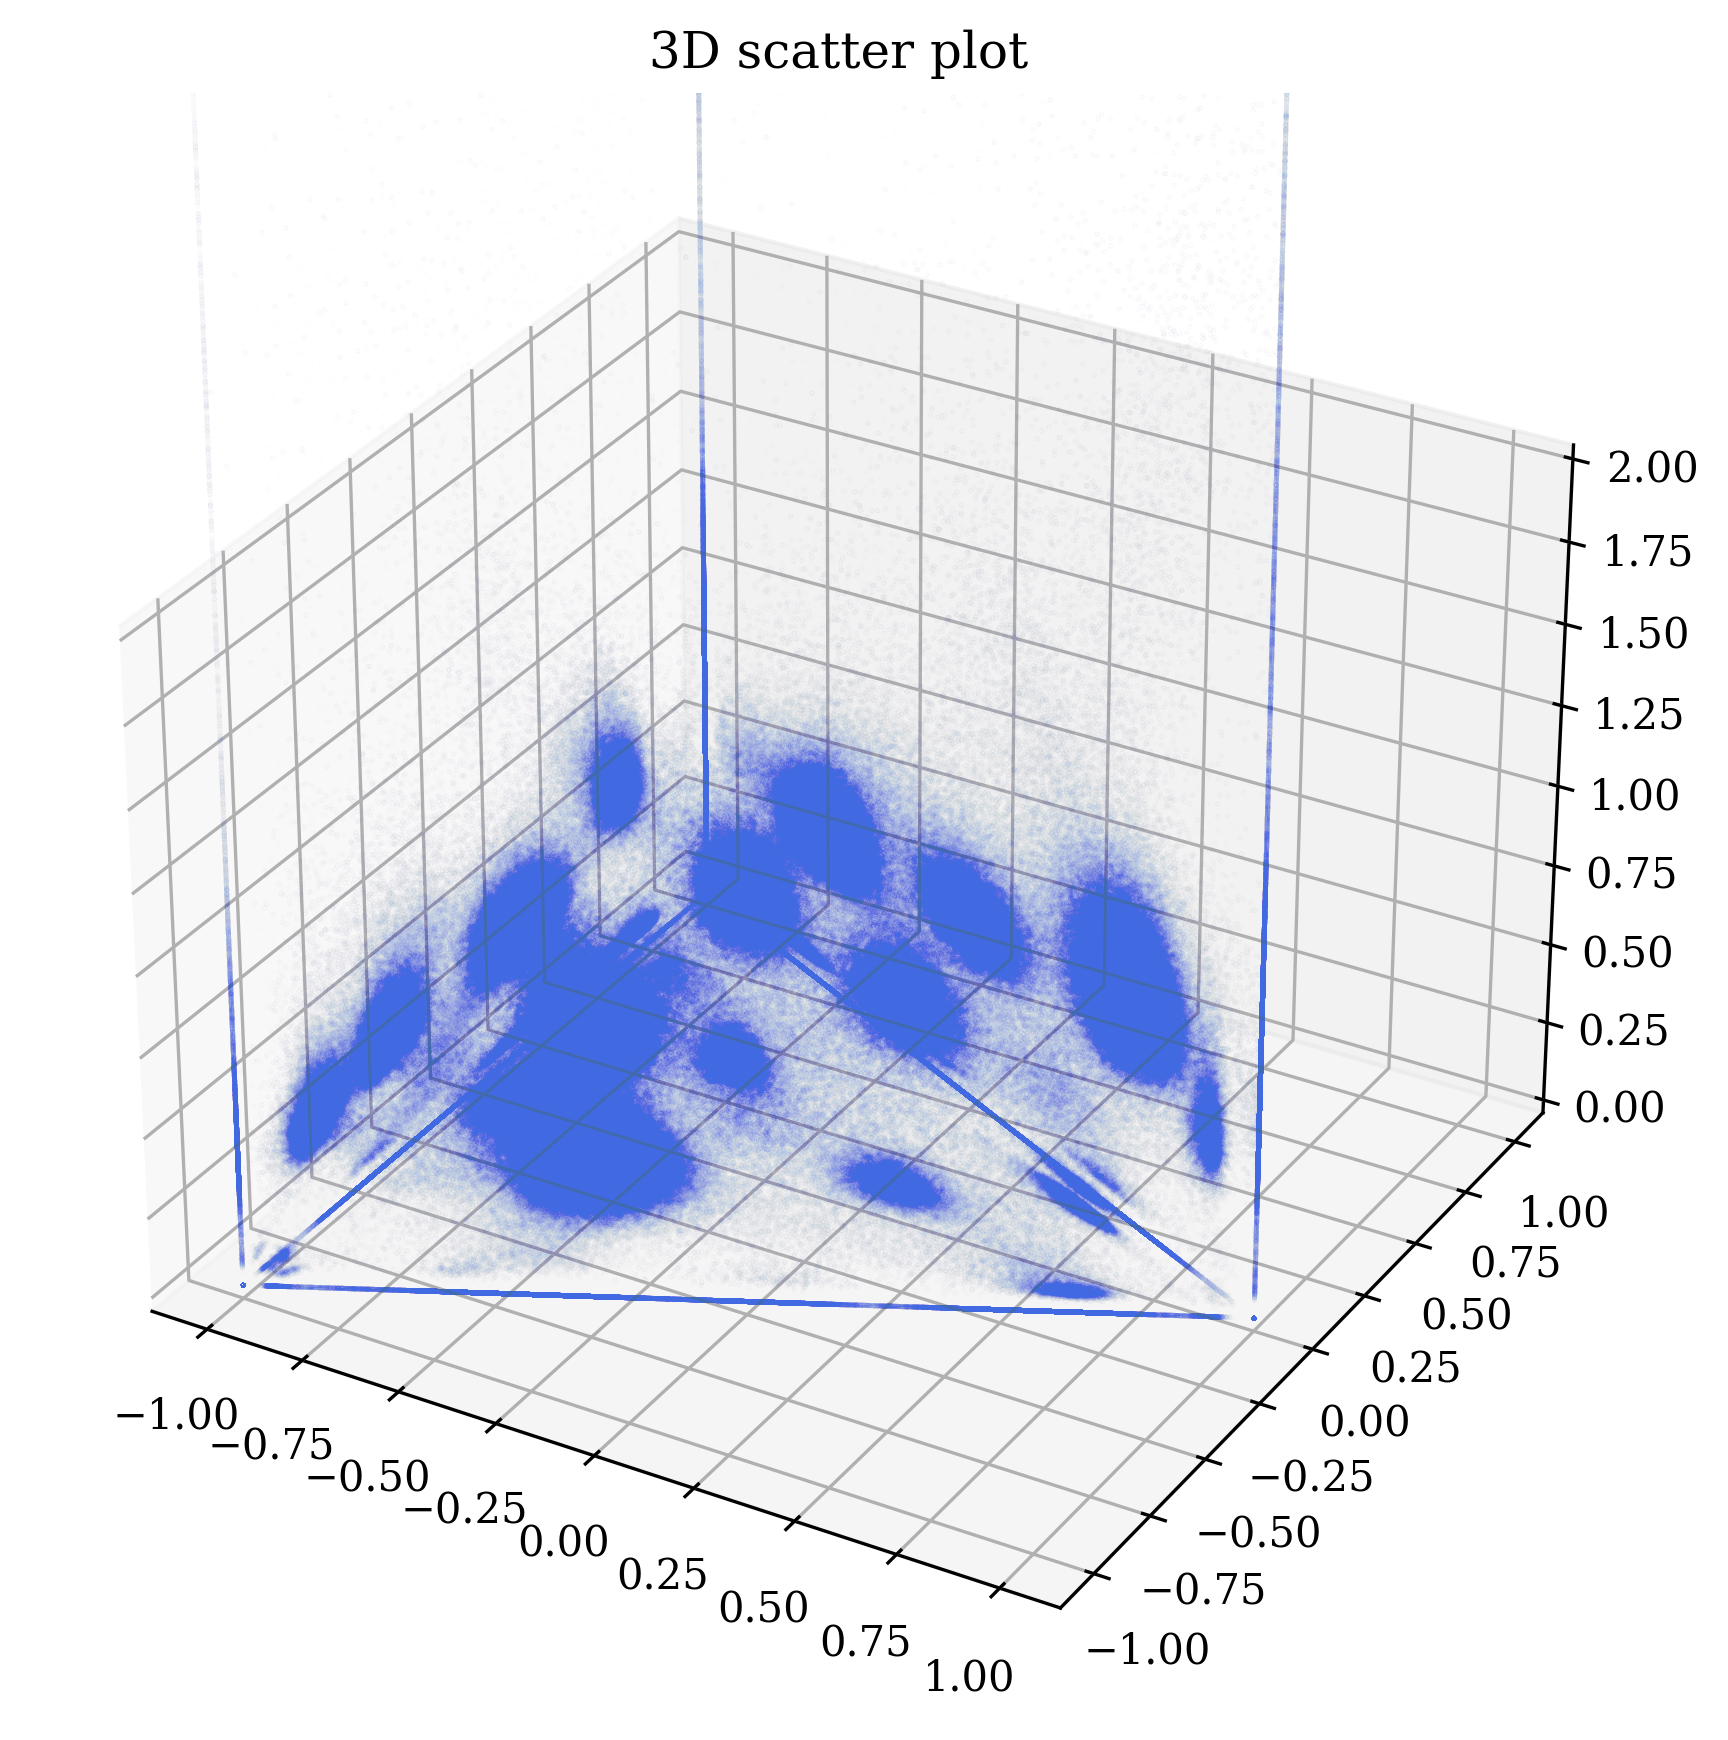

In [77]:
#3D plot
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
ax.scatter3D(intensity_all['X_coor'], intensity_all['Y_coor'], intensity_all['G/A'], color = "royalblue",s=0.1,alpha=0.006)
ax.set_zlim3d(0,2)
plt.title("3D scatter plot")
plt.savefig(read_dir/'colorcoding_3D.jpg')

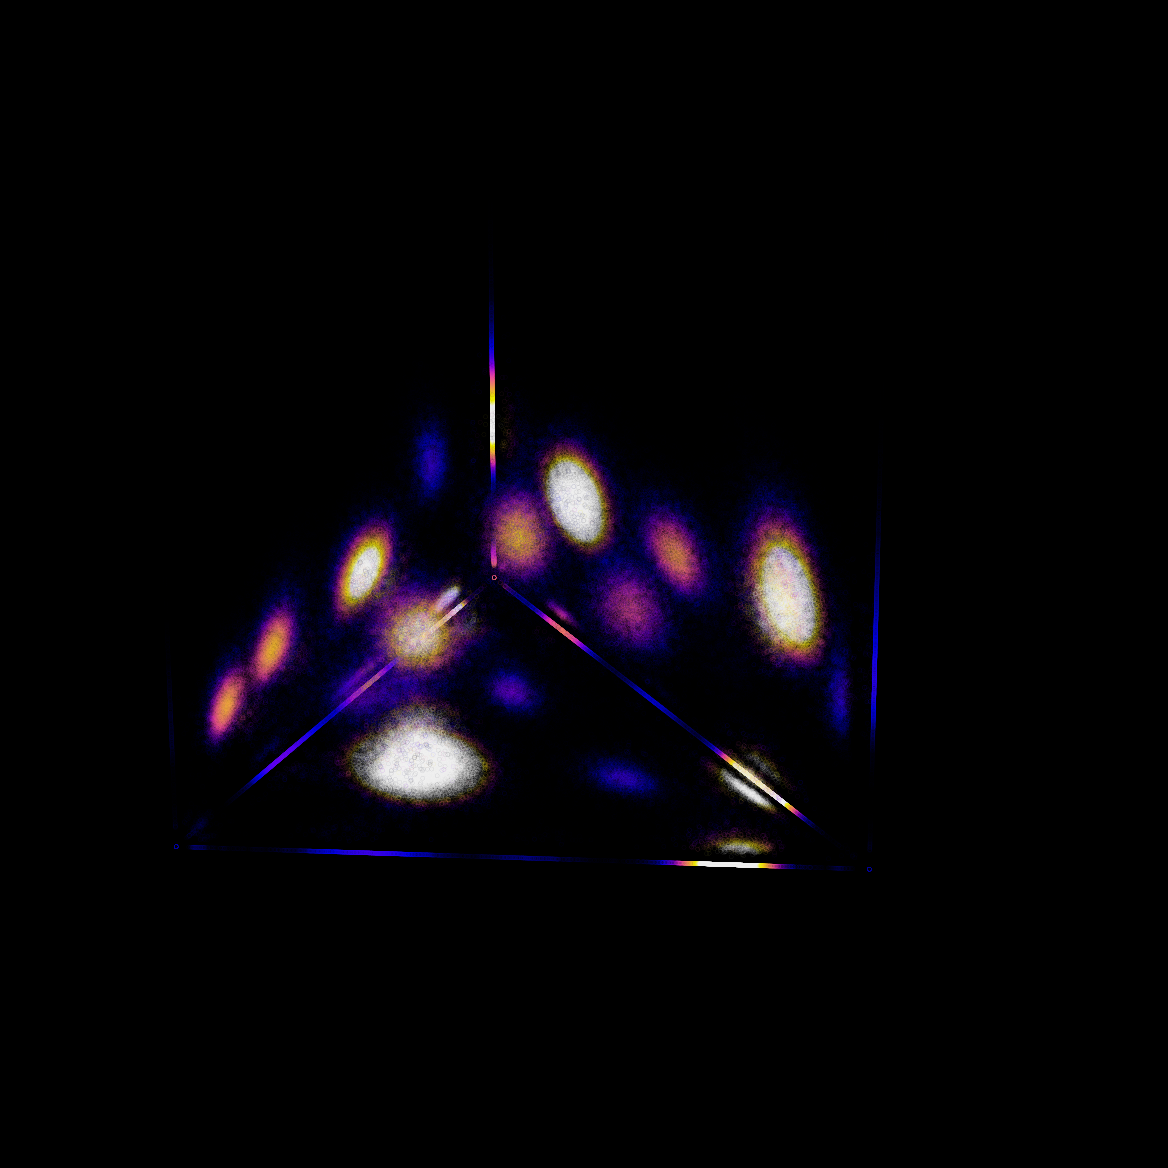

In [78]:
from scipy import stats

sample = intensity_all[['X_coor','Y_coor','G/A']].sample(frac=0.05,replace=True, random_state=1)
sample = sample[sample['G/A']<20]

mu, sigma = 0, 0.1 
x = np.array(sample['X_coor'])
y = np.array(sample['Y_coor'])
z = np.array(sample['G/A'])

xyz = np.vstack([x,y,z])
density = stats.gaussian_kde(xyz)(xyz) 

idx = density.argsort()
x, y, z, density = x[idx], y[idx], z[idx], density[idx]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, c=density, cmap=plt.cm.gnuplot2 ,s=0.0012,vmin=0, vmax=2)
ax.set_zlim3d(0,1.5)
fig.set_facecolor('black')
ax.set_facecolor('black') 
ax.grid(False) 
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_axis_off()
plt.savefig(read_dir/'3D_density_sampled_2.jpg')